In [23]:
#!pip install langdetect
#!pip install pyLDAvis
#!pip install spacy==3.0.5
#!pip install spacy-spanish-lemmatizer==0.6
#!spacy download es_core_news_sm
#!python3 -m spacy_spanish_lemmatizer download wiki

import langdetect  # language detection
import nltk  # natural language processing
from nltk.corpus import words
from nltk.stem.wordnet import WordNetLemmatizer
import numpy  # arrays and matrices
import pandas  # dataframes
import pyLDAvis  # plotting
import pyLDAvis.sklearn  # plotting
import regex  # regular expressions
import string
from unicodedata import normalize
import sklearn  # machine learning
import spacy
import spacy_spanish_lemmatizer
from html import unescape
from numbers import Number
from joblib import Parallel, delayed
from pytictoc import TicToc
tictoc = TicToc()

# added to suppress warnings coming from pyLDAvis
import warnings
warnings.filterwarnings('ignore')

# plotting
import matplotlib.pyplot
%matplotlib inline

In [18]:
# installing specific word dictionarys
# used for stopword removal and lemmatization

nltk.download("words")
nltk.download("wordnet")
nltk.download("stopwords")

nlp = spacy.load("es_core_news_sm")
nlp.replace_pipe("lemmatizer", "spanish_lemmatizer")

stopwords = set(pandas.read_csv("stopwords/stopwords.csv").word.tolist())
stopwords = set([i for i in stopwords if type(i) == str])
print(f'Cantidad de stopwords: {len(stopwords)}')

[nltk_data] Downloading package words to /home/alexander/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alexander/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alexander/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cantidad de stopwords: 608


In [19]:
path = 'agregado_vacantes_scraping_20210712.xlsx'
df = pandas.read_excel(path)
df = df.drop_duplicates()
df = df[['Cargo','Descripcion','Educacion requerida','Experiencia requerida (meses)','Tipo de empleo','Empresa','Sector',
         'Cantidad de aplicantes','Fecha de publicacion','Fecha de expiracion','Ciudad','Pais']]
print("SHAPE:\n{shape}\n".format(shape=df.shape))
print("COLUMN NAMES:\n{names}\n".format(names=df.columns.tolist()))
df.head()

SHAPE:
(2613, 12)

COLUMN NAMES:
['Cargo', 'Descripcion', 'Educacion requerida', 'Experiencia requerida (meses)', 'Tipo de empleo', 'Empresa', 'Sector', 'Cantidad de aplicantes', 'Fecha de publicacion', 'Fecha de expiracion', 'Ciudad', 'Pais']



,Cargo,Descripcion,Educacion requerida,Experiencia requerida (meses),Tipo de empleo,Empresa,Sector,Cantidad de aplicantes,Fecha de publicacion,Fecha de expiracion,Ciudad,Pais
0,DevOps Senior Engineer,&lt;p&gt;&lt;strong&gt;Position Overview&lt;/s...,bachelor degree,72.0,FULL_TIME,Qual.IT,NaN,NaN,2021-07-12T18:58:44.000Z,2021-08-11T18:58:44.000Z,Medellín,CO
1,Asesor Comercial experiencia en Belleza,Importante empresa esta solicitando Asesor Com...,bachelor degree,NaN,FULL_TIME,reclutapro.com,"Marketing y publicidad,Servicios y tecnologías...",NaN,2021-07-07T10:27:59.000Z,2021-08-06T10:27:59.000Z,Medellín,CO
2,Ejecutivo de Ventas - Writing,&lt;strong&gt;Position: &lt;/strong&gt;Ejecuti...,NaN,NaN,FULL_TIME,Newell Brands,Artículos de consumo,NaN,2021-07-12T22:35:42.000Z,2021-08-11T22:35:41.000Z,Medellín,CO
3,Desarrollador de Android,Buscamos profesionales en ingeniería de sistem...,bachelor degree,NaN,OTHER,NAPOLEON SYSTEMS,NaN,NaN,2021-07-08T19:56:46.000Z,2021-08-07T19:56:46.000Z,Medellín,CO
4,Analista de Estrategia y Planeación de Rutas,&lt;p&gt;Nos encontramos en la búsqueda de un ...,bachelor degree,NaN,FULL_TIME,Viva,Aeronáutica/Aviación,174 solicitudes,2021-07-06T22:47:27.000Z,2021-08-05T22:47:26.000Z,Medellín,CO


In [10]:
# define quick look function for data frame
#def dataframe_quick_look(df, nrows):
#    print("SHAPE:\n{shape}\n".format(shape=df.shape))
#    print("COLUMN NAMES:\n{names}\n".format(names=df.columns))
#    print("HEAD:\n{head}\n".format(head=df.head(nrows)))  
#dataframe_quick_look(df, nrows=2)

In [20]:
# data set came with prespecified topics
# print the topics out with counts

print("TOPICS:\n{topics}\n".format(topics=df["Cargo"].value_counts()))

TOPICS:
Lead DevOps Engineer                                53
Middle DevOps Engineer                              43
Senior DevOps Engineer                              36
Senior Automation Tester                            35
Senior JavaScript Developer                         28
                                                    ..
Junior Project Manager Trainee (Remote Position)     1
Data Architect                                       1
Account Executive                                    1
Vendedor                                             1
Consultor Comercial                                  1
Name: Cargo, Length: 743, dtype: int64



In [12]:
# view final data that will be carried forward

raw = df['Descripcion'].tolist()
print("HEADLINES:\n{lines}\n".format(lines=raw[:2]))
print("LENGTH:\n{length}\n".format(length=len(raw)))

HEADLINES:
["&lt;p&gt;&lt;strong&gt;Position Overview&lt;/strong&gt;&lt;/p&gt;&lt;p&gt;We are looking for a Senior DevOps to join our rapidly growing development team. The applicant will have a mix of deep technical skills together with excellent client-facing consulting and communication skills. You will be responsible for delivering high quality solutions. This position is for an individual who is pro-active, ambitious and eager to succeed and become part of a rapidly growing company.&lt;/p&gt;&lt;p&gt;&amp;nbsp;&lt;/p&gt;&lt;p&gt;&lt;strong&gt;Who you are&lt;/strong&gt;&lt;/p&gt;&lt;ul&gt;&lt;li&gt;You like building modern and reliable production systems&lt;/li&gt;&lt;li&gt;Years of experience taught you that anyone could write code, but&amp;nbsp;writing&amp;nbsp;code that others understand is an art you value&lt;/li&gt;&lt;li&gt;You’re curious: you know that making mistakes is how one gains experience&lt;/li&gt;&lt;li&gt;You like to challenge and be challenged, opened to change and

In [61]:
# check language of headline, filter to spanish only
def do_language_identif(txt):
    lg = 'none'
    try: lg = langdetect.detect(txt)
    except: pass
    if lg != 'es': return ''
    return txt

def do_clean_html(txt):
    cleantxt = unescape(str(txt))
    cleanr = regex.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return regex.sub(cleanr, ' ', cleantxt)

def do_clean_stopwords(txt):
    out = [t for t in txt.split(" ") if t.lower() not in stopwords]
    return " ".join(out)

# define function to cleaning data
def do_clean_text(txt):
    txt = txt.lower()
    
    # Remove text in square brackets, remove punctuation and remove words containing numbers.
    txt = txt.replace("ñ", "nh")
    txt = regex.sub(r"\[.*?¿\]\%", " ", txt)
    txt = regex.sub(r"https://", "", txt)
    txt = regex.sub(r"www.", "", txt)
    txt = regex.sub(r"[‘’“”…«»]", "", txt)
    txt = regex.sub(r'["\[\]\{\}]', "", txt)
    txt = regex.sub(r"_", " ", txt)
    txt = regex.sub(r"[%s]" % regex.escape(string.punctuation), " ", txt)
    txt = regex.sub(r"\w*\d\w*", "", txt)
    txt = regex.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize("NFD", txt), 0, regex.I
    )
    txt = regex.sub(r"\n", " ", txt)
    txt = regex.sub(r"&lt;/?.*?&gt;", " &lt;&gt; ", txt)

    # Eliminar caracteres que se repitan más de dos veces seguidas
    pattern = regex.compile(r"(.)\1{2,}")
    txt = pattern.sub(r"\1\1", txt)
    
    return txt.strip()

# define function to perform lemmatization
def do_lemmatizing(txt):
    out = [word.lemma_ for word in nlp(txt)]
    return out

# define cleaning words short than 3 characters
def do_clean_short_words(tokens):
    tokens = [i for i in tokens if len(str(i)) >= 3]
    return tokens

# define function to execute pipeline pre-processing
def do_prepare_pipeline(element, pipeline):
    inout_data = element if not isinstance(element, Number) else str(element)
    for transform in pipeline:
        inout_data = transform(inout_data)
    return inout_data if inout_data and len(inout_data) > 0 else None

# define pipeline to text pre-processing
pipeline = [
    do_clean_html, 
    do_language_identif,
    do_clean_text,
    do_clean_stopwords,
    do_lemmatizing,
    do_clean_short_words
]

#r = do_prepare_pipeline(raw[0], pipeline)
#print(len(r), r) if r else print("Void")

In [62]:
# apply cleaning function to every vacancy
#clean = list(map(do_text_cleaning, raw))
tictoc.tic()
clean = Parallel(n_jobs=24)(delayed(do_prepare_pipeline)(txt, pipeline) for txt in raw)
tictoc.toc('Elapsed time')

Elapsed time 630.854981 seconds.


In [66]:
# remove none types
clean = list(filter(None.__ne__, clean))
print("HEADLINES:\n{lines}\n".format(lines=clean[:2]))
print("LENGTH:\n{length}\n".format(length=len(clean)))

HEADLINES:
[['importante', 'empresa', 'solicitar', 'asesor', 'comercial', 'experiencia', 'belleza', 'experiencia', 'venta', 'sector', 'retail', 'horario', 'domingo', 'domingo', 'turno', 'rotativo', 'dia', 'compensatorio', 'semana', 'salario', 'minimo', 'legal', 'vigente', 'auxilio', 'transporte', 'prestación', 'ley', 'disponibilidad', 'viajar', 'disponibilidad', 'cambio', 'residencia'], ['position', 'ejecutivo', 'venta', 'canal', 'moderno', 'business', 'unit', 'writing', 'location', 'medellin', 'reports', 'sales', 'manager', 'ejecutivo', 'venta', 'estaras', 'cargo', 'canal', 'moderno', 'superficie', 'supermercados', 'independiente', 'region', 'medellin', 'antioquia', 'relacion', 'comercial', 'principal', 'cliente', 'identificar', 'oportunidad', 'desarrollar', 'ejecucion', 'plan', 'comercial', 'garantizar', 'crecimiento', 'terminos', 'sell', 'sell', 'out', 'distribucion', 'rentabilidad', 'responsibilities', 'definicion', 'ejecucion', 'seguimiento', 'plan', 'comercial', 'regional', 'desa

In [67]:
# turn tokens back into strings
# concatenate using whitespaces
clean_sentences = [" ".join(i) for i in clean]
clean_sentences[:2]

['importante empresa solicitar asesor comercial experiencia belleza experiencia venta sector retail horario domingo domingo turno rotativo dia compensatorio semana salario minimo legal vigente auxilio transporte prestación ley disponibilidad viajar disponibilidad cambio residencia',
 'position ejecutivo venta canal moderno business unit writing location medellin reports sales manager ejecutivo venta estaras cargo canal moderno superficie supermercados independiente region medellin antioquia relacion comercial principal cliente identificar oportunidad desarrollar ejecucion plan comercial garantizar crecimiento terminos sell sell out distribucion rentabilidad responsibilities definicion ejecucion seguimiento plan comercial regional desarrollar cliente canal moderno lograr objetivo asignado identificacion oportunidad zonas cliente canal moderno permitir crecimiento acelerado canal desarrollo ejecucion plan comercial cliente garantizar crecimiento terminos sell distribucion rentabilidad re

In [68]:
# save to backup data cleaned
pandas.DataFrame(data=clean_sentences, columns=["data"]).to_csv("clean_vacancies_20210712.csv")

### Count Vectorizer

In [69]:
# define some global variables
number_words = 10
number_docs = 10

# load data cleaned
clean_sentences = pandas.read_csv("clean_vacancies_20210712.csv").data.tolist()

In [120]:
# Clean data with anothers stopwords
other_stopwords = ['aa', 'about', 'adicional', 'afín', 'anhos', 'asignado', 'capacidad', 'client', 'cliente', 'clientes', 
                   'competencias', 'conocimiento', 'conocimientos', 'contact', 'debera', 'description', 'empresa', 'equipo', 
                   'espacio', 'excelente', 'habilidad', 'importante', 'ma', 'manejo', 'nivel', 'offer', 'oportunidad', 'os', 
                   'our', 'perfil', 'persona', 'quote', 'ref', 'responsabilidad', 'sector', 'seguimiento', 'siguiente', 
                   'solicitud', 'successful', 'the', 'what']

other_mappings =  dict({'applicant':'solicitante','gestia³n':'gestion','job':'trabajo',
                        'comunicacia³n':'comunicacion','informacia³n':'informacion'})

def do_clean_others_stopwords(txt):
    out = [t for t in txt.split(" ") if t not in other_stopwords]
    return " ".join(out)

def do_clean_others_mappings(txt):
    out = [other_mappings.get(t,t) for t in txt.split(" ")]
    return " ".join(out)

#do_clean_others_mappings("applicant comunicacia³n gestia³n informacia³n job experiencia venta retail")

clean_sentences = list(map(do_clean_others_stopwords, clean_sentences))
clean_sentences = list(map(do_clean_others_mappings, clean_sentences))
clean_sentences[:2]

['solicitar asesor comercial experiencia belleza experiencia venta retail horario domingo domingo turno rotativo dia compensatorio semana salario minimo legal vigente auxilio transporte prestación ley disponibilidad viajar disponibilidad cambio residencia',
 'position ejecutivo venta canal moderno business unit writing location medellin reports sales manager ejecutivo venta estaras cargo canal moderno superficie supermercados independiente region medellin antioquia relacion comercial principal identificar desarrollar ejecucion plan comercial garantizar crecimiento terminos sell sell out distribucion rentabilidad responsibilities definicion ejecucion plan comercial regional desarrollar canal moderno lograr objetivo identificacion zonas canal moderno permitir crecimiento acelerado canal desarrollo ejecucion plan comercial garantizar crecimiento terminos sell distribucion rentabilidad realizacion periodica revision plan negocios identificacion realizacion evaluacion plan accion lograr obj

In [152]:
# execute bag of words model
# use raw term counts for lda 
# as it is a probabilistic graphical model

vectorizer1 = sklearn.feature_extraction.text.CountVectorizer(
    analyzer="word",
    max_df=0.5, 
    min_df=0.1, 
    max_features=1000
)
clean_vec1 = vectorizer1.fit_transform(clean_sentences)
print(clean_vec1[0])

feature_names_vec1 = vectorizer1.get_feature_names()

  (0, 9)	2
  (0, 28)	1


In [151]:
len(feature_names_vec1), feature_names_vec1

(29,
 ['aa',
  'administrativo',
  'cargo',
  'carrera',
  'comunicacion',
  'cumplimiento',
  'cumplir',
  'desarrollo',
  'estrategia',
  'experiencia',
  'gestion',
  'industrial',
  'informacion',
  'liderazgo',
  'ma',
  'negocio',
  'os',
  'personal',
  'proceso',
  'producto',
  'profesional',
  'reporta',
  'requerimiento',
  'resultado',
  'servicio',
  'sistema',
  'solicitante',
  'trabajo',
  'venta'])

### Select Number of Topics

In [125]:
# define function to calculate perplexity for LDA model trained on ntopics

def perplexity_by_ntopic(data, ntopics):
    output_dict = {
        "Number Of Topics": [], 
        "Perplexity Score": []
    }
    
    for t in ntopics:
        lda = sklearn.decomposition.LatentDirichletAllocation(
            n_components=t,
            learning_method="online",
            random_state=0,
            n_jobs=-1
        )
        lda.fit(data)
        
        output_dict["Number Of Topics"].append(t)
        output_dict["Perplexity Score"].append(lda.perplexity(data))
        
    output_df = pandas.DataFrame(output_dict)
    
    index_min_perplexity = output_df["Perplexity Score"].idxmin()
    output_num_topics = output_df.loc[
        index_min_perplexity,  # index
        "Number Of Topics"  # column
    ]
        
    return (output_df, output_num_topics)

In [126]:
# find perplexity scores for several different numbers of topics
# takes several minutes

tictoc.tic()
df_perplexity, optimal_num_topics = perplexity_by_ntopic(
    clean_vec1, 
    ntopics=[1, 2, 3, 4, 6, 8, 10, 11, 12, 13, 14, 15]
)
print(df_perplexity)
tictoc.toc('Elapsed time')

    Number Of Topics  Perplexity Score
0                  1         25.558875
1                  2         24.483241
2                  3         24.203606
3                  4         23.943639
4                  6         24.251250
5                  8         24.119842
6                 10         23.787718
7                 11         23.749652
8                 12         24.344091
9                 13         24.491307
10                14         24.503529
11                15         24.535145
Elapsed time 18.236666 seconds.


<AxesSubplot:xlabel='Number Of Topics'>

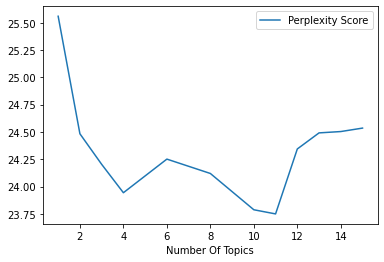

In [127]:
df_perplexity.plot.line("Number Of Topics", "Perplexity Score")

In [138]:
optimal_num_topics = 4

In [139]:
# define and fit LDA model

lda = sklearn.decomposition.LatentDirichletAllocation(
    n_components=optimal_num_topics,
    learning_method="online",
    random_state=0,
    n_jobs=-1
)
lda.fit(clean_vec1)

LatentDirichletAllocation(learning_method='online', n_components=4, n_jobs=-1,
                          random_state=0)

In [140]:
# output matrix
# h: docs to topics

lda_transform = lda.transform(clean_vec1)
print(lda_transform.shape)
print(lda_transform)

(1440, 4)
[[0.07051811 0.80366798 0.06266961 0.0631443 ]
 [0.01888004 0.85662523 0.0179009  0.10659384]
 [0.89146737 0.03688621 0.0358741  0.03577232]
 ...
 [0.25       0.25       0.25       0.25      ]
 [0.36182394 0.08787356 0.08359285 0.46670964]
 [0.74193181 0.08820274 0.08342806 0.08643739]]


In [141]:
# output matrix
# w: words to topics

lda_components = lda.components_
print(lda_components.shape)
print(lda_components)

(4, 29)
[[3.64677447e+00 1.96849698e+02 9.67258205e+01 1.32202693e+02
  8.55103924e+00 3.33028947e+01 1.06821629e+01 1.78091750e+02
  3.97166661e+01 6.86352607e+02 3.34904586e+02 1.00261972e+02
  2.69214322e-01 6.88236391e+01 1.33133709e+00 7.77682139e+01
  1.01857152e+00 8.21145413e-01 2.98093378e+02 2.66391828e-01
  4.19042958e+02 2.50514229e-01 1.29948505e+01 2.82731109e-01
  1.32827279e+00 1.70170040e+02 4.23021698e+01 2.49450038e+01
  2.59913518e-01]
 [2.09381969e+02 3.72264540e+00 9.36788531e+01 7.65501818e+01
  6.99126824e+00 9.95602377e-01 2.76140833e+02 1.20091141e+02
  1.66827109e+02 4.77965128e+02 3.33576748e+00 1.12606211e+02
  3.21225232e-01 1.23863195e+01 8.57485002e+01 6.55994764e+01
  2.22389057e+02 1.39119919e+01 4.78726467e+01 3.27652904e+02
  3.22723025e+02 2.50413127e-01 1.96533756e+02 8.72683254e+00
  2.78168411e+01 2.68954989e+01 1.42578883e+02 3.31654130e+02
  3.39844129e+02]
 [2.06298976e+02 2.62428691e-01 1.71857385e+00 2.98672010e+00
  4.19877949e-01 2.0774792

In [142]:
# define function to reformat output matrices into easily readable tables

def get_topics(mod, vec, names, docs, ndocs, nwords):
    # word to topic matrix
    W = mod.components_
    W_norm = W / W.sum(axis=1)[:, numpy.newaxis]
    # topic to document matrix
    H = mod.transform(vec)
    
    W_dict = {}
    H_dict = {}
    
    for tpc_idx, tpc_val in enumerate(W_norm):
        topic = "Topic{}".format(tpc_idx)
        
        # formatting w
        W_indices = tpc_val.argsort()[::-1][:nwords]
        W_names_values = [
            (round(tpc_val[j], 4), names[j]) 
            for j in W_indices
        ]
        W_dict[topic] = W_names_values
        
        # formatting h
        H_indices = H[:, tpc_idx].argsort()[::-1][:ndocs]
        H_names_values = [
            (round(H[:, tpc_idx][j], 4), docs[j]) 
            for j in H_indices
        ]
        H_dict[topic] = H_names_values
        
    W_df = pandas.DataFrame(
        W_dict, 
        index=["Word" + str(i) for i in range(nwords)]
    )
    H_df = pandas.DataFrame(
        H_dict,
        index=["Doc" + str(i) for i in range(ndocs)]
    )
        
    return (W_df, H_df)

In [143]:
# run function

W_df, H_df = get_topics(
    mod=lda,
    vec=clean_vec1,
    names=feature_names_vec1,
    docs=raw,
    ndocs=number_docs, 
    nwords=number_words
)

In [144]:
# word-topic table
print(W_df)

                         Topic0                   Topic1  \
Word0     (0.2334, experiencia)    (0.1284, experiencia)   
Word1     (0.1425, profesional)          (0.0913, venta)   
Word2         (0.1139, gestion)        (0.0891, trabajo)   
Word3         (0.1013, proceso)       (0.0881, producto)   
Word4  (0.0669, administrativo)    (0.0867, profesional)   
Word5      (0.0605, desarrollo)        (0.0742, cumplir)   
Word6         (0.0579, sistema)             (0.0598, os)   
Word7         (0.0449, carrera)             (0.0563, aa)   
Word8      (0.0341, industrial)  (0.0528, requerimiento)   
Word9           (0.0329, cargo)     (0.0448, estrategia)   

                      Topic2                    Topic3  
Word0  (0.2486, informacion)        (0.2872, servicio)  
Word1           (0.2315, ma)        (0.1512, personal)  
Word2      (0.1757, reporta)    (0.1451, comunicacion)  
Word3           (0.1437, aa)     (0.131, cumplimiento)  
Word4           (0.1089, os)       (0.0818, resultado)

In [145]:
# document-topic table
print(H_df)

                                                 Topic0  \
Doc0  (0.944, persona con buena presentación persona...   
Doc1  (0.944, CompromisoAlta capacidad de interpreta...   
Doc2  (0.944, CompromisoLiderazgoBuen manejo de pers...   
Doc3  (0.9309, TECNOLOGO EN QUIMICA APLIACA A LA IND...   
Doc4  (0.9158, &lt;p&gt;&lt;strong&gt;Acerca de nues...   
Doc5  (0.9158, Persona con Experiencia en Contabilid...   
Doc6  (0.9158, &lt;strong&gt;&lt;u&gt;About Astound ...   
Doc7  (0.9158, &lt;p&gt;&lt;strong&gt;PERFIL&lt;/str...   
Doc8  (0.9158, At Johnson &amp;amp; Johnson, the lar...   
Doc9  (0.9158, &lt;strong&gt;Perfil&lt;br&gt;&lt;br&...   

                                                 Topic1  \
Doc0  (0.9766, We are currently looking for a &lt;st...   
Doc1  (0.9766, &lt;strong&gt;&lt;u&gt;About Alert Lo...   
Doc2  (0.9766, Currently we are looking for a &lt;st...   
Doc3  (0.9766, Análisis y diseño de base de datos re...   
Doc4  (0.9766, Currently, we are looking for a &lt;s...

### Visualizing LDA

In [146]:
# iterative visualization
# featuring pca biplot and histogram
lda_plot = pyLDAvis.sklearn.prepare(lda, clean_vec1, vectorizer1, R=10)
pyLDAvis.enable_notebook()
pyLDAvis.display(lda_plot)

In [147]:
# define functiont to fit and plot t-SNE model

def plot_tsne(data, threshold):
    # filter data according to threshold
    index_meet_threshold = numpy.amax(data, axis=1) >= threshold
    lda_transform_filt = data[index_meet_threshold]
    
    # fit tsne model
    # x-d -> 2-d, x = number of topics
    tsne = sklearn.manifold.TSNE(
        n_components=2, 
        verbose=0, 
        random_state=0, 
        angle=0.5, 
        init='pca'
    )
    tsne_fit = tsne.fit_transform(lda_transform_filt)
    
    # most probable topic for each headline
    most_prob_topic = []
    for i in range(tsne_fit.shape[0]):
        most_prob_topic.append(lda_transform_filt[i].argmax())
    
    print("LENGTH:\n{}\n".format(len(most_prob_topic)))

    unique, counts = numpy.unique(
        numpy.array(most_prob_topic), 
        return_counts=True
    )

    print("COUNTS:\n{}\n".format(numpy.asarray((unique, counts)).T))
    
    # make plot
    matplotlib.pyplot.figure(figsize=(10,6))
    #color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r']
    color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    for i in list(set(most_prob_topic)):
        indices = [idx for idx, val in enumerate(most_prob_topic) if val == i]
        matplotlib.pyplot.scatter(
            x=tsne_fit[indices, 0], 
            y=tsne_fit[indices, 1], 
            s=0.5, 
            c=color_list[i], 
            label='Topic' + str(i),
            alpha=1
        )
    
    
    matplotlib.pyplot.xlabel('x-tsne')
    matplotlib.pyplot.ylabel('y-tsne')
    matplotlib.pyplot.legend(markerscale=10)

LENGTH:
1440

COUNTS:
[[  0 561]
 [  1 300]
 [  2 294]
 [  3 285]]



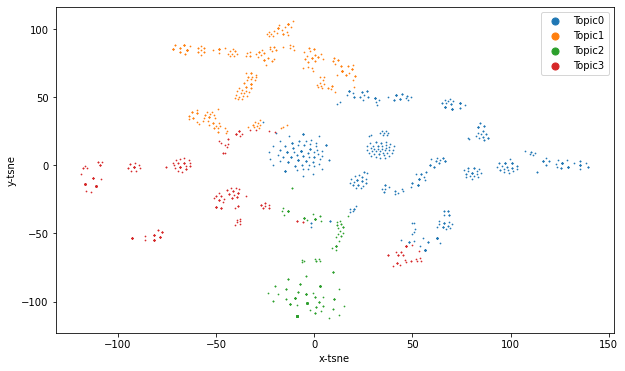

In [148]:
plot_tsne(data=lda_transform, threshold=0)

In [ ]:
# define and fit nmf model

nmf = sklearn.decomposition.NMF(
    n_components=optimal_num_topics,
    init="nndsvda",
    solver="mu",
    beta_loss="frobenius",
    random_state=0, 
    alpha=0.1, 
    l1_ratio=0.5
)
nmf.fit(clean_vec1)

In [ ]:
# run function to produce nice output tables

W_df, H_df = get_topics(
    mod=nmf,
    vec=clean_vec1,
    names=feature_names_vec1,
    docs=raw,
    ndocs=number_docs, 
    nwords=number_words
)

In [ ]:
# word-topic table
print(W_df)

In [ ]:
# document-topic table
print(H_df)

In [ ]:
# output raw document-topic matrix for t-SNE plot
nmf_transform = nmf.transform(clean_vec1)
print(nmf_transform.shape)
print(nmf_transform)

In [ ]:
# run function to produce t-SNE plot
plot_tsne(data=nmf_transform, threshold=0)